In [ ]:
using JPEC, Plots
# test

    Updating registry at `~/.julia/registries/General.toml`
   Installed ADTypes ─ v1.16.0
    Updating `~/Github/JPEC/Project.toml`
  [0c46a032] + DifferentialEquations v7.16.1
  [91a5bcdd] + Plots v1.40.17
  [37e2e46d] ~ LinearAlgebra ⇒ v1.11.0
  [44cfe95a] ~ Pkg ⇒ v1.11.0
  [de0858da] ~ Printf ⇒ v1.11.0
  [8dfed614] ~ Test ⇒ v1.11.0
    Updating `~/Github/JPEC/Manifest.toml`
  [47edcb42] + ADTypes v1.16.0
  [7d9f7c33] + Accessors v0.1.42
  [79e6a3ab] + Adapt v4.3.0
  [66dad0bd] + AliasTables v1.1.3
  [a95523ee] + AlmostBlockDiagonals v0.1.10
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.19.0
  [4c555306] + ArrayLayouts v1.11.2
  [aae01518] + BandedMatrices v1.9.4
  [d1d4a3ce] + BitFlags v0.1.9
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.6
  [764a87c0] + BoundaryValueDiffEq v5.18.0
  [7227322d] + BoundaryValueDiffEqAscher v1.8.0
  [56b672f2] + BoundaryValueDiffEqCore v1.11.1
  [85d9eb09] + BoundaryValueDiffEqFIRK v1.9.0
  [1a22d4ce] + BoundaryValueDiff

In [5]:
kappa = 1.6 # elongation
a = 0.33 # minor radius
r0 =1.0 # major radius
q0 = 1.9 # safety factor at r0
p0fac = 1.0 # >= 1
b0fac = 1.0
f0fac = 1.0

mr = 128
mz = 128
ma = 128

r = zeros(mr)
z = zeros(mz)
rg = zeros(mr,mz)
zg = zeros(mr,mz)

# psi_in = bicube(mr, mz, 1)
# sq_in = spline(ma,4)

println("equilibrium of shape: ", mr, "x", mz, " and radially resolved: ", ma)

equilibrium of shape: 128x128 and radially resolved: 128


In [6]:
ro, zo = 0., 0.
f0 = r0*b0fac
psio = kappa * f0 * a^2 / (2 * q0 * r0)
psifac = psio / (a*r0)^2
efac = 1/kappa^2
pfac = 2*psio^2*(kappa^2+1)/(a*r0*kappa)^2
rmin = r0-1.5*a
rmax = r0+1.5*a
zmin = -1.5*kappa*a
zmax = -zmin

0.7920000000000001

In [7]:
#linspace(0,1,mr)
rhos = collect(range(0, stop=1, length=ma))
psis = rhos .^2
sqfs = zeros(ma, 4)
sqfs[:, 1] .= f0*f0fac
sqfs[:, 2] .= pfac * (p0fac .- rhos)
sqfs[:, 3] .= 0
sqfs[:, 4] .= rhos

psifs = zeros(mr, mz, 1)

sq_in = JPEC.SplinesMod.spline_setup(psis, sqfs; bctype=3)
rs = collect(range(rmin, stop=rmax, length=mr))
zs = collect(range(zmin, stop=zmax, length=mz))
for i in 1:mr
    for j in 1:mz
        psifs[i, j, 1] = psio - psifac * (efac * (rs[i] * zs[j])^2 + (rs[i]^2-r0^2)^2/4)
    end
end

psi_in = JPEC.SplinesMod.bicube_setup(rs, zs, psifs; bctypex=3, bctypey=3)

JPEC.SplinesMod.BicubicSpline.BicubicSplineType(Ptr{Nothing} @0x00000002b31ece00, [0.505, 0.5127952755905512, 0.5205905511811023, 0.5283858267716536, 0.5361811023622047, 0.5439763779527559, 0.551771653543307, 0.5595669291338583, 0.5673622047244095, 0.5751574803149606  …  1.4248425196850394, 1.4326377952755907, 1.4404330708661417, 1.448228346456693, 1.456023622047244, 1.4638188976377953, 1.4716141732283465, 1.4794094488188976, 1.4872047244094488, 1.495], [-0.7920000000000001, -0.7795275590551183, -0.7670551181102364, -0.7545826771653544, -0.7421102362204726, -0.7296377952755907, -0.7171653543307088, -0.704692913385827, -0.692220472440945, -0.6797480314960631  …  0.6797480314960631, 0.692220472440945, 0.704692913385827, 0.7171653543307088, 0.7296377952755907, 0.7421102362204726, 0.7545826771653544, 0.7670551181102364, 0.7795275590551183, 0.7920000000000001], [-0.03887765822368422 -0.038055505244839305 … -0.038055505244839305 -0.03887765822368422; -0.03845847939104394 -0.03761074869491475

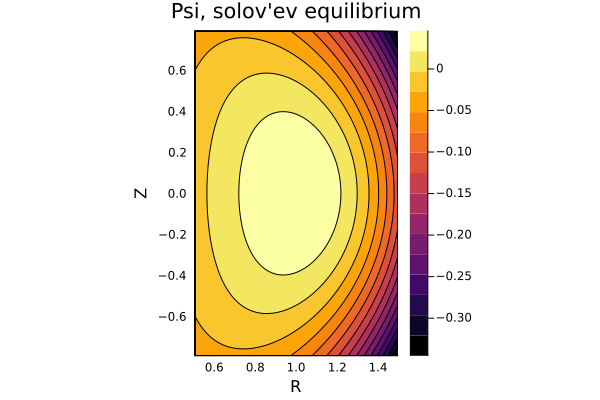

In [8]:
# Make a contour plot of the bicubic spline
xs_fine = collect(range(rmin, stop=rmax, length=110))
ys_fine = collect(range(zmin, stop=zmax, length=100))
fs_fine = JPEC.SplinesMod.bicube_eval(psi_in, xs_fine, ys_fine)
# plot the bicubic spline
p1 = contourf(xs_fine, ys_fine, fs_fine[:, :, 1]', label="psi", legend=:topright)
title!("Psi, solov'ev equilibrium")
xlabel!("R")
ylabel!("Z")
# equal axis scales
plot(p1, aspect_ratio=:equal)
xlims!(rmin, rmax)
ylims!(zmin, zmax)

In [ ]:
struct SingSurface
    m::Int
    psifac::Float64
    rho::Float64
    q::Float64
    q1::Float64
end

function sing_find(sq, psiex::Vector{Float64}, qex::Vector{Float64}, nn::Int, mex::Int; itmax::Int=200, nsing::Int=1000)
    qsing   = Vector{Float64}(undef, nsing)
    q1sing  = Vector{Float64}(undef, nsing)
    psising = Vector{Float64}(undef, nsing)
    sing_surfaces = Vector{SingSurface}()
    ising = 0

    for iex in 2:mex
        dq = qex[iex] - qex[iex-1]
        m  = floor(Int, nn * qex[iex-1])
        if dq > 0
            m += 1
        end
        dm = sign(1.0 * dq * nn)   

        while (m - nn * qex[iex-1]) * (m - nn * qex[iex]) <= 0
            it = 0
            psifac0 = psiex[iex-1]
            psifac1 = psiex[iex]

            while true
                it += 1
                psifac = (psifac0 + psifac1) / 2
                spline_eval!(sq, psifac, 0)
                singfac = (m - nn * sq[4]) * dm
                if singfac > 0
                    psifac0 = psifac
                    psifac = (psifac + psifac1) / 2
                else
                    psifac1 = psifac
                    psifac = (psifac + psifac0) / 2
                end
                if abs(singfac) <= 1e-12
                    break
                end
                if it > itmax
                    error("sing_find: can't find root")
                end
            end

            # Store surface
            ising += 1
            spline_eval!(sq, psifac, 1)
            qsing[ising]   = m / nn
            q1sing[ising]  = sq.f1[4]
            psising[ising] = psifac
            m += dm
        end
    end

    for idx in 1:ising
        push!(sing_surfaces, SingSurface(
            floor(Int, qsing[idx] * nn),   # m
            psising[idx],                  # psifac
            sqrt(psising[idx]),            # rho
            qsing[idx],                    # q
            q1sing[idx]                    # q1
        ))
    end

    return sing_surfaces
end

sing_find (generic function with 1 method)

In [ ]:
sing_find(mex=1, nn=1, sq=)